In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

from tqdm import tqdm

from mcp_us_airline.utils import io_utils

/tmp/ipykernel_1070416/2932075248.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_supplied_OD_counts(supplied_itineraries, flights_df):
    supplied_OD_counts = []

    for itinerary in tqdm(supplied_itineraries):
        list_of_flights = itinerary[-1]
        first_flight = list_of_flights[0]
        last_flight = list_of_flights[-1]

        origin = flights_df[flights_df['id'] == first_flight]['origin'].values[0]
        destination = flights_df[flights_df['id'] == last_flight]['destination'].values[0]

        supplied_OD_counts.append((origin, destination))

    supplied_OD_counts_df = pd.DataFrame(supplied_OD_counts, columns=['origin', 'destination'])
    supplied_OD_counts_df = supplied_OD_counts_df.groupby(['origin', 'destination']).size().reset_index(name='supply_count')

    return supplied_OD_counts_df

def log_bin(x, y, n_bins):
    """
    Perform logarithmic binning of x-y data.
    
    Parameters:
    -----------
    x : array-like
        x values
    y : array-like 
        y values
    n_bins : int
        Number of logarithmic bins
        
    Returns:
    --------
    bin_centers : array
        Centers of the logarithmic bins
    bin_means : array
        Mean y values in each bin
    bin_stds : array
        Standard deviation of y values in each bin
    bin_counts : array
        Number of points in each bin
    """
    
    # Convert inputs to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Create logarithmic bins
    log_bins = np.logspace(np.log10(x.min()), np.log10(x.max()), n_bins+1)
    bin_centers = np.sqrt(log_bins[1:] * log_bins[:-1])
    
    # Initialize arrays for results
    bin_means = np.zeros(n_bins)
    bin_stds = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    # Bin the data
    for i in range(n_bins):
        mask = (x >= log_bins[i]) & (x < log_bins[i+1])
        if np.sum(mask) > 0:
            bin_means[i] = np.mean(y[mask])
            bin_stds[i] = np.std(y[mask])
            bin_counts[i] = np.sum(mask)
        else:
            bin_means[i] = np.nan
            bin_stds[i] = np.nan
            bin_counts[i] = 0
            
    return bin_centers, bin_means, bin_stds, bin_counts


In [3]:
'''
scatter plots if supply vs. demand, where each point is an origin/destination pair, 
one coordinate is given by the supply provided via the MCP model, 
the other given by the input demand -> two versions: sold tickets and gravity model demand


todo:
    - how about log-binning?
    - match y scale?
'''

db1b_file = "../data/derived/DB1B_demand_Y2023_Q2.dat"
db1b_df = pd.read_csv(db1b_file, sep=" ", names=["origin", "destination", "demand"])
db1b_df.rename(columns={"demand": "DB1B_demand"}, inplace=True)

gravity_file = "../data/derived/gravity_demand_Y2023_M4_D18.csv"
gravity_df = pd.read_csv(gravity_file)
gravity_df = gravity_df[['super_airport_1', 'super_airport_2', 'demand']]
gravity_df.rename(columns={"super_airport_1": "origin", "super_airport_2": "destination", "demand": "gravity_demand"}, inplace=True)

In [4]:
db1b_supplied_file = "../data/results/Y2023M4D18/results_db1b_non_coop_distance_r1.dat"
db1b_supplied_data = io_utils.read_data_file(db1b_supplied_file)

gravity_supplied_file = "../data/results/Y2023M4D18/results_gravity_pop1_1.0_pop2_1.0_decay_2.0_d_300_distance_r1.dat"
gravity_supplied_data = io_utils.read_data_file(gravity_supplied_file)


flights_df = pd.read_csv("../data/derived/list_of_super_flights_Y2023_M4_D18.dat", 
                        sep=" ", 
                        names=['id', 'origin', 'destination', 'departure', 'arrival', 'time', 'seats', 'distance'])

In [ ]:
# db1b_supplied_df = get_supplied_OD_counts(db1b_supplied_data, flights_df)
# gravity_supplied_df = get_supplied_OD_counts(gravity_supplied_data, flights_df)
# db1b_supplied_df.to_csv("../data/results/db1b_supplied_OD_counts.csv", index=False)
# gravity_supplied_df.to_csv("../data/results/gravity_supplied_OD_counts.csv", index=False)

In [5]:
drop_na = False

db1b_supplied_df = pd.read_csv("../data/results/db1b_supplied_OD_counts.csv")
gravity_supplied_df = pd.read_csv("../data/results/gravity_supplied_OD_counts.csv")

db1b_supplied_df.rename(columns={"supply_count": "DB1B_supply"}, inplace=True)
gravity_supplied_df.rename(columns={"supply_count": "gravity_supply"}, inplace=True)

db1b_merged_df = pd.merge(db1b_df, db1b_supplied_df, on=["origin", "destination"], how="outer")
gravity_merged_df = pd.merge(gravity_df, gravity_supplied_df, on=["origin", "destination"], how="outer")

if drop_na:

    db1b_merged_df.dropna(inplace=True)
    gravity_merged_df.dropna(inplace=True)

    db1b_merged_df['log_DB1B_demand'] = np.log(db1b_merged_df['DB1B_demand'])
    db1b_merged_df['log_DB1B_supply'] = np.log(db1b_merged_df['DB1B_supply'])

    gravity_merged_df['log_gravity_demand'] = np.log(gravity_merged_df['gravity_demand'])
    gravity_merged_df['log_gravity_supply'] = np.log(gravity_merged_df['gravity_supply'])

else:

    db1b_merged_df.fillna(0, inplace=True)
    gravity_merged_df.fillna(0, inplace=True)

    db1b_merged_df['log_DB1B_demand'] = np.log(db1b_merged_df['DB1B_demand'] + 1.0)
    db1b_merged_df['log_DB1B_supply'] = np.log(db1b_merged_df['DB1B_supply'] + 1.0)

    gravity_merged_df['log_gravity_demand'] = np.log(gravity_merged_df['gravity_demand'] + 1.0)
    gravity_merged_df['log_gravity_supply'] = np.log(gravity_merged_df['gravity_supply'] + 1.0)

print(f"db1b_merged_df count: {len(db1b_merged_df)}")
print(f"gravity_merged_df count: {len(gravity_merged_df)}")


lb_db1b_demand, lb_db1b_supply, lb_db1b_std, lb_db1b_count = log_bin(db1b_merged_df['DB1B_demand'] + 1.0, db1b_merged_df['DB1B_supply'] + 1.0, 15)
lb_gravity_demand, lb_gravity_supply, lb_gravity_std, lb_gravity_count = log_bin(gravity_merged_df['gravity_demand'] + 1.0, gravity_merged_df['gravity_supply'] + 1.0, 15)


db1b_merged_df count: 46250
gravity_merged_df count: 75754


/nobackup/mk139/anaconda3/envs/airline-spp-application/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)
/nobackup/mk139/anaconda3/envs/airline-spp-application/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  k, _ = kurtosistest(a, axis)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.138e+04
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           5.49e-18
Time:                        16:59:11   Log-Likelihood:                 17.786
No. Observations:                  12   AIC:                            -31.57
Df Residuals:                      10   BIC:                            -30.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0270      0.053    -38.180      0.0

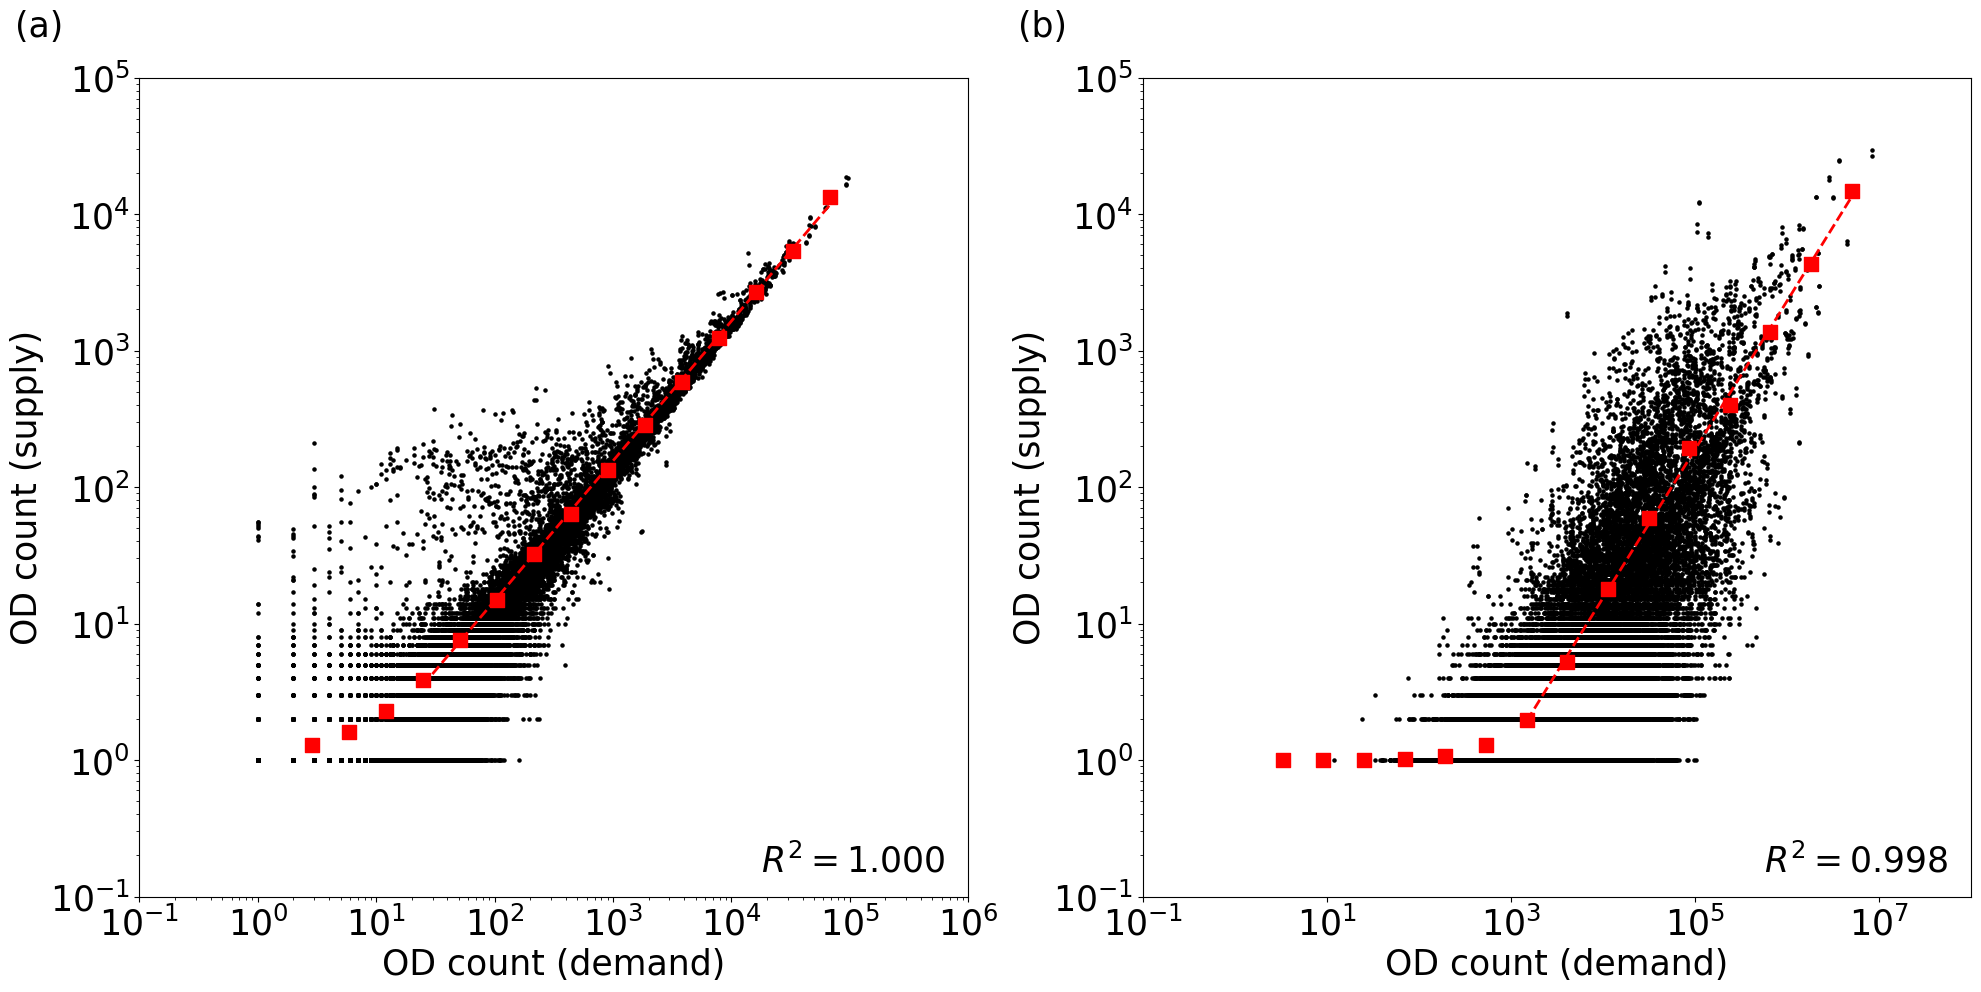

In [6]:
###### results by log transformed data & linear regression ######

# db1b_merged_df.dropna(inplace=True)
# gravity_merged_df.dropna(inplace=True)

# model1 = 'log_DB1B_supply ~ log_DB1B_demand'
# model2 = 'log_gravity_supply ~ log_gravity_demand'

# results1 = smf.ols(formula=model1, data=db1b_merged_df).fit()
# results2 = smf.ols(formula=model2, data=gravity_merged_df).fit()

# print(results1.summary())
# print(results2.summary())

# x1 = np.linspace(db1b_merged_df['log_DB1B_demand'].min(), db1b_merged_df['log_DB1B_demand'].max(), 200)
# y1 = results1.params.Intercept + results1.params.log_DB1B_demand * x1
# x1 = np.exp(x1)
# y1 = np.exp(y1)

# x2 = np.linspace(gravity_merged_df['log_gravity_demand'].min(), gravity_merged_df['log_gravity_demand'].max(), 200)
# y2 = results2.params.Intercept + results2.params.log_gravity_demand * x2
# x2 = np.exp(x2)
# y2 = np.exp(y2)


##### results by log-binning & linear regression ######

start_idx = 3

lb_db1b_x = np.log(lb_db1b_demand)[start_idx:]
lb_db1b_y = np.log(lb_db1b_supply)[start_idx:]

lb_db1b_x = sm.add_constant(lb_db1b_x)
results_lb_db1b = sm.OLS(lb_db1b_y, lb_db1b_x).fit()

x3 = np.linspace(np.log(lb_db1b_demand[start_idx:].min()), np.log(lb_db1b_demand[start_idx:].max()), 200)
y3 = results_lb_db1b.params[0] + results_lb_db1b.params[1] * x3
x3 = np.exp(x3)
y3 = np.exp(y3)


start_idx = 6

lb_gravity_x = np.log(lb_gravity_demand)[start_idx:]  
lb_gravity_y = np.log(lb_gravity_supply)[start_idx:] 

lb_gravity_x = sm.add_constant(lb_gravity_x)
results_lb_gravity = sm.OLS(lb_gravity_y, lb_gravity_x).fit()

x4 = np.linspace(np.log(lb_gravity_demand[start_idx:].min()), np.log(lb_gravity_demand[start_idx:].max()), 200)
y4 = results_lb_gravity.params[0] + results_lb_gravity.params[1] * x4
x4 = np.exp(x4)
y4 = np.exp(y4)

print(results_lb_db1b.summary())
print(results_lb_gravity.summary())




##### visualization ######


fig, ax = plt.subplots(ncols=2,figsize=(20, 10))

ax[0].scatter(db1b_merged_df["DB1B_demand"], db1b_merged_df["DB1B_supply"], s=5, c='k')
# ax[0].plot(x1, y1, color='orange', linewidth=2, ls='--')


ax[0].scatter(lb_db1b_demand, lb_db1b_supply, s=100, marker='s',c='red')
ax[0].plot(x3, y3, color='red', linewidth=2, ls='--')


ax[0].set_xlabel("OD count (demand)", fontsize=25)
ax[0].set_ylabel("OD count (supply)", fontsize=25)
ax[0].tick_params('both', labelsize=25)
ax[0].text(0.75, 0.03, 
        fr"$R^2={results_lb_db1b.rsquared:.3f}$", transform=ax[0].transAxes, fontsize=25)
ax[0].set_xlim(1e-1, 1e6)
ax[0].set_ylim(1e-1, 1e5)
ax[0].loglog()





ax[1].scatter(gravity_merged_df["gravity_demand"], gravity_merged_df["gravity_supply"], s=5, c='k')
# ax[1].plot(x2, y2, color='orange', linewidth=2, ls='--')


ax[1].scatter(lb_gravity_demand, lb_gravity_supply, s=100, marker='s', c='red')
ax[1].plot(x4, y4, color='red', linewidth=2, ls='--')

ax[1].set_xlabel("OD count (demand)", fontsize=25)
ax[1].set_ylabel("OD count (supply)", fontsize=25)
ax[1].tick_params('both', labelsize=25)
ax[1].text(0.75, 0.03, 
        fr"$R^2={results_lb_gravity.rsquared:.3f}$", transform=ax[1].transAxes, fontsize=25)
ax[1].set_xlim(1e-1, 1e8)
ax[1].set_ylim(1e-1, 1e5)
ax[1].loglog()


ax[0].text(-0.15, 1.05, "(a)", transform=ax[0].transAxes, fontsize=25)
ax[1].text(-0.15, 1.05, "(b)", transform=ax[1].transAxes, fontsize=25)
plt.tight_layout()



plt.savefig("../results/manuscript/SM-supply-demand-comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

